In [1]:
#!pip  install subword-nmt
#!pip install nltk
#!pip install torchtext==0.11.0
#!pip install transformers

In [2]:
import pandas as pd
from transformers import AutoTokenizer

In [3]:
phoenix_dataset_dev = '/Users/alua/Desktop/PHOENIX-2014-T.dev.corpus.csv'
phoenix_dataset_test = '/Users/alua/Desktop/PHOENIX-2014-T.test.corpus.csv'
phoenix_dataset_train = '/Users/alua/Desktop/PHOENIX-2014-T.train.corpus.csv'
# Load the Phoenix dataset
phoenix_dev = pd.read_csv(phoenix_dataset_dev, sep="|")
phoenix_test = pd.read_csv(phoenix_dataset_test, sep="|")
phoenix_train = pd.read_csv(phoenix_dataset_train, sep="|")


In [4]:
phoenix_all = pd.concat([phoenix_dev, phoenix_test, phoenix_train])

In [5]:
phoenix_all.shape

(8257, 7)

In [6]:
phoenix_all.head(5)

,name,video,start,end,speaker,orth,translation
0,11August_2010_Wednesday_tagesschau-2,11August_2010_Wednesday_tagesschau-2/1/*.png,-1,-1,Signer08,DRUCK TIEF KOMMEN,tiefer luftdruck bestimmt in den nächsten tage...
1,11August_2010_Wednesday_tagesschau-3,11August_2010_Wednesday_tagesschau-3/1/*.png,-1,-1,Signer08,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...,das bedeutet viele wolken und immer wieder zum...
2,11August_2010_Wednesday_tagesschau-8,11August_2010_Wednesday_tagesschau-8/1/*.png,-1,-1,Signer08,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...,meist weht nur ein schwacher wind aus untersch...
3,25October_2010_Monday_tagesschau-22,25October_2010_Monday_tagesschau-22/1/*.png,-1,-1,Signer01,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...,am mittwoch hier und da nieselregen in der nor...
4,05May_2011_Thursday_tagesschau-25,05May_2011_Thursday_tagesschau-25/1/*.png,-1,-1,Signer08,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...,und nun die wettervorhersage für morgen freita...


In [7]:
phoenix_need = phoenix_all[['translation', 'orth']]

In [8]:
phoenix_need.head(5)

,translation,orth
0,tiefer luftdruck bestimmt in den nächsten tage...,DRUCK TIEF KOMMEN
1,das bedeutet viele wolken und immer wieder zum...,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...
2,meist weht nur ein schwacher wind aus untersch...,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...
3,am mittwoch hier und da nieselregen in der nor...,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...
4,und nun die wettervorhersage für morgen freita...,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...


In [9]:
phoenix_need = phoenix_need.rename(columns={"translation": "src", "orth": "trg"})

In [10]:
phoenix_need.to_csv('phoenix_need.csv', sep="\t", index = False)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [12]:
from transformers import BertTokenizer
from transformers import RobertaTokenizer

In [13]:
path = '/Users/alua/Desktop/work_study/DiplomaMSAI/workspace0/phoenix_need.csv'

In [14]:
import transformers

print(transformers.__version__)

4.25.1


In [15]:
model_checkpoint = "mariav/helsinki-opus-de-en-fine-tuned-wmt16"

In [16]:
from datasets import load_metric
metric = load_metric("sacrebleu")

/var/folders/fn/71jqbgcd6kg5ckn934wqkvzh0000gn/T/ipykernel_25415/3063495125.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [17]:
phoenix_need.head(3)

,src,trg
0,tiefer luftdruck bestimmt in den nächsten tage...,DRUCK TIEF KOMMEN
1,das bedeutet viele wolken und immer wieder zum...,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...
2,meist weht nur ein schwacher wind aus untersch...,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...


In [18]:
tokenizer_SRC = AutoTokenizer.from_pretrained(model_checkpoint)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [19]:
tokenizer_W = WordPunctTokenizer()
#tokenizer_W = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenizer_TRG(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [20]:
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_tf=True)
# Extract the encoder
encoder_model = model.model.encoder
encoder_model.eval()

All TF 2.0 model weights were used when initializing MarianMTModel.

All the weights of MarianMTModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MarianMTModel for predictions without further training.


MarianEncoder(
  (embed_tokens): Embedding(58101, 512, padding_idx=58100)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0): MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): SiLUActivation()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=Tr

In [21]:
trg_sentenceLst = phoenix_need.trg
import re
pattern = re.compile(r'\s+|-')

words = []
for sentence in trg_sentenceLst:
  words.append(re.split(pattern, sentence))
tokenizer_W = WordPunctTokenizer()
#tokenizer_W = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenizer_TRG(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [22]:
tokens = []
for sentence in trg_sentenceLst:
  tokens.append(tokenizer_TRG(sentence))
trg_tokens = [token for lst in tokens for token in lst]
len(trg_tokens)

67219

In [23]:
trg_unique_tokens = set(trg_tokens)
print('unique tokens in TRG: ',len(trg_unique_tokens))

unique tokens in TRG:  976


In [24]:
SRC = Field(tokenize=tokenizer_SRC.tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
           lower = False)

TRG = Field(tokenize=tokenizer_TRG,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [25]:
dataset = TabularDataset(
    path=path,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [26]:
# split the dataset into training, validation, and test sets
train_data, valid_data, test_data = dataset.split(split_ratio=[0.75, 0.15, 0.1],
                                                  stratified=False)

In [27]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 6194
Number of validation examples: 825
Number of testing examples: 1239


In [28]:
TRG.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in target (gloss) vocabulary: {len(TRG.vocab)}")

Unique tokens in target (gloss) vocabulary: 1371


In [29]:
SRC.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in source (origin) vocabulary: {len(SRC.vocab)}")

Unique tokens in source (origin) vocabulary: 486


Length distribution in Train data


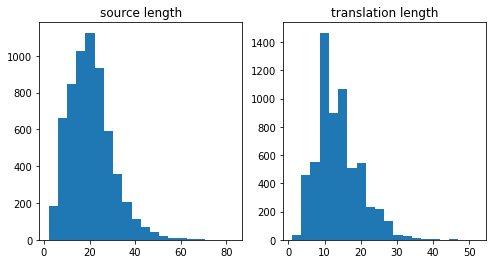

In [30]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);


In [31]:
SRC.vocab.itos[::1000]

['<unk>']

In [32]:
TRG.vocab.itos[::1000]

['<unk>', 'gleich']

In [33]:
print(vars(train_data.examples[9]))

{'trg': ['die', 'nächsten', 'tage', 'werden', 'etwas', 'kühler', 'bei', 'uns', 'die', 'wetterlage', 'stellt', 'sich', 'leicht', 'um'], 'src': ['▁IN', '-', 'KOMMEN', 'D', '▁B', 'ISS', 'CHEN', '▁K', 'UE', 'HL', '▁W', 'IND', '▁B', 'ISS', 'CHEN', '▁', 'UM', 'KE', 'HREN']}


Length distribution in Test data


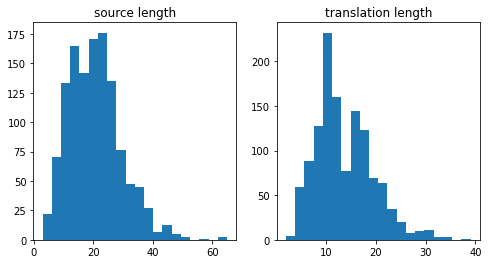

In [34]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [36]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [37]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 32]
	[.trg]:[torch.LongTensor of size 28x32]
	[.src]:[torch.LongTensor of size 47x32]
torch.Size([47, 32]) torch.Size([28, 32])


In [38]:
INPUT_DIM = len(SRC.vocab)
print('INPUT_DIM', INPUT_DIM)
OUTPUT_DIM = len(TRG.vocab)
print('OUTPUT_DIM', OUTPUT_DIM)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = encoder_model.config.hidden_size
print('HID_DIM', HID_DIM)

DROPOUT = 0.5
DEC_LAYERS = 2
DEC_HEADS = 8

INPUT_DIM 486
OUTPUT_DIM 1371
HID_DIM 512


In [39]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        return x, attention


In [40]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        return x


In [41]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]

        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                          
        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
              
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        # print('attention', attention.shape)
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
        # print('output3', output.shape)
        # [32, 25, 1381]
        return output, attention

In [42]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg)) 
        #trg = [batch size, trg len, hid dim]    
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        return trg, attention

In [43]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        # The first target token has a mask of [1, 0, 0, 0, 0] which means it can only look at the first target token. 
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        src = src.permute(1, 0)
        trg = trg.permute(1, 0)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        enc_src = self.encoder(src)[0]
        #print('enc_src', enc_src.shape)
        #enc_src = [batch size, src len, hid dim]
       
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        #print('attention3', attention.shape)
        # [32, 8, 38, 52]
        return output, attention

In [44]:
enc = encoder_model
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_EMB_DIM, 
              DROPOUT, 
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [46]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 54,852,955 trainable parameters


In [47]:
PAD_IDX = TRG.vocab.stoi['<pad>']
LEARNING_RATE = 0.0005

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
#optimizer = optim.Adam(model.parameters())

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [48]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        
        output, attention = model(src, trg)
        #print('output', output.shape)
        # [32, 43, 1354]
        #print('trg', trg.shape)
        # [32, 27]
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        output = output.permute(1, 0, 2)
        #trg = trg.permute(1, 0)
        
        # Reshape tensor to [ (trg sent len - 1) * batch size, output dim]
        output = output[:-1, :, :].reshape(-1, output.shape[-1])
        #print('output', output.shape)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        #print('loss', loss)
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)


In [49]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output = output.permute(1, 0, 2)
            
            output = output[:-1, :, :].reshape(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

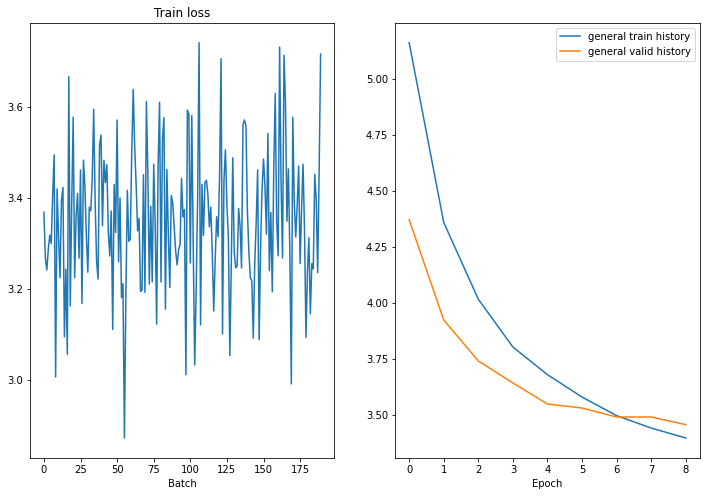

Epoch: 10 | Time: 11m 7s
	Train Loss: 3.349 | Train PPL:  28.483
	 Val. Loss: 3.467 |  Val. PPL:  32.049


In [51]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [52]:
import utils
import imp

In [53]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [54]:
batch = next(iter(test_iterator))

In [55]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    
    generate_translation(src, trg, model, TRG.vocab)

Original: es weht ein schwacher bis mäßiger wind aus östlichen richtungen
Generated: gelten schwach schwacher bis mäßiger an aus süd frischer

Original: dabei kann es sehr glatt werden
Generated: gibt es auch windig werden



In [56]:
import tqdm

In [57]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output, _ = model(src, trg) #turn off teacher forcing
        output = output.permute(1, 0, 2)
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
    
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

#original_text = flatten(original_text)
#generated_text = flatten(generated_text)

39it [00:17,  2.17it/s]


In [58]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu([[text] for text in original_text], generated_text) * 100

7.318857943422062